# Face Mask Detector
In this workshop, we'll build an object detection model using the YOLO (You Only Look Once) algorithm, a highly efficient and accurate ML algorithm that processes images using a single pass of a neural network.

We will be building an AI face mask detector to demonstrate the real-world implementations (ie. during the COVID-19 pandemic) of YOLO and CV machine learning models overall. [This](https://www.kaggle.com/datasets/andrewmvd/face-mask-detection/code?datasetId=667889&sortBy=voteCount) face mask image dataset from Kaggle will serve as both our training and validation data.

Run this block to ensure that the selected runtime is a NVIDIA Tesla T4 GPU. If not, go to Runtime —> Change runtime type and select T4 GPU under Hardware accelerator.

In [1]:
!nvidia-smi

Wed Feb 25 19:32:24 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 1. Preparation
First, gather and label the data necessary for the model. For the purpose of this workshop, the data has already been pre-processed. Colab has a useful feature that allows you to directly access Kaggle datasets from your notebook, so run the following block to import our dataset.

In [2]:
from google.colab import drive
import kagglehub

drive.mount('/content/drive')
path = kagglehub.dataset_download("andrewmvd/face-mask-detection")

# Display the path to the Kaggle dataset within our notebook
print(path)

Mounted at /content/drive
Using Colab cache for faster access to the 'face-mask-detection' dataset.
/kaggle/input/face-mask-detection


### 1.1 Copy dataset
Copy the data from our specified path into our desired dataset folder.

In [3]:
!cp -a /kaggle/input/face-mask-detection/ /content/

### 1.2 Convert to .txt
Convert the annotations (labels) into .txt format, since Ultralytics can only read plain text files, using this [PASCAL VOC to YOLO label converter](https://github.com/pylabel-project/pylabel).

In [4]:
!pip install pylabel
from pylabel import importer
dataset = importer.ImportVOC(path='/content/face-mask-detection/annotations')
dataset.export.ExportToYoloV5()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 72.8 MB/s eta 0:00:00


Exporting YOLO files...: 100%|██████████| 853/853 [00:01<00:00, 517.77it/s]


['training/dataset.yaml',
 'training/labels/maksssksksss498.txt',
 'training/labels/maksssksksss457.txt',
 'training/labels/maksssksksss431.txt',
 'training/labels/maksssksksss770.txt',
 'training/labels/maksssksksss601.txt',
 'training/labels/maksssksksss719.txt',
 'training/labels/maksssksksss133.txt',
 'training/labels/maksssksksss330.txt',
 'training/labels/maksssksksss650.txt',
 'training/labels/maksssksksss381.txt',
 'training/labels/maksssksksss206.txt',
 'training/labels/maksssksksss278.txt',
 'training/labels/maksssksksss312.txt',
 'training/labels/maksssksksss99.txt',
 'training/labels/maksssksksss773.txt',
 'training/labels/maksssksksss788.txt',
 'training/labels/maksssksksss19.txt',
 'training/labels/maksssksksss800.txt',
 'training/labels/maksssksksss827.txt',
 'training/labels/maksssksksss574.txt',
 'training/labels/maksssksksss164.txt',
 'training/labels/maksssksksss361.txt',
 'training/labels/maksssksksss233.txt',
 'training/labels/maksssksksss393.txt',
 'training/label

Clean up our file structure, replacing the .xml annotations with our converted .txt annotations in our `face-mask-detection` directory.

In [5]:
# We'll be creating our own YAML file with the correct formatting later
!rm -f '/content/training/dataset.yaml'

!rm -r '/content/face-mask-detection/annotations/'
!mv '/content/training/labels/' '/content/face-mask-detection/labels/'

# Remove empty directory
!rm -r '/content/training/'

### 1.3 Create folder structure
Ultralytics, which will be used to train the YOLO model, requires a particular folder structure for its stored data:

*   **Training** — Images used to train the model. Each epoch (iteration) of training, every image in this subset is passed through the model's neural network. The training algorithm then adjusts its weights to better fit the images, aka "learning" from the data.
*   **Validation** — Images used to test the model's accuracy. The model analyzes images that it wasn't trained on (which are completely new to this version of the model) to determine how well it was trained at the end of each epoch.

Each folder contains two sub-folders, one for images and one for labels. This keeps the actual images separate from the annotations. We'll be using a Python script (written by EdjeElectronics on GitHub) to randomly split our dataset into **training** (*80% of original*) and **validation** (*20% of original*) subsets.

In [6]:
!wget -O /content/train_val_split.py https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/utils/train_val_split.py

!python train_val_split.py --datapath="/content/face-mask-detection" --train_pct=0.8

--2026-02-25 19:33:38--  https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/utils/train_val_split.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3203 (3.1K) [text/plain]
Saving to: ‘/content/train_val_split.py’

/content/train_val_ 100%[===================>]   3.13K  --.-KB/s    in 0s      

2026-02-25 19:33:38 (58.6 MB/s) - ‘/content/train_val_split.py’ saved [3203/3203]

Created folder at /content/data/train/images.
Created folder at /content/data/train/labels.
Created folder at /content/data/validation/images.
Created folder at /content/data/validation/labels.
Number of image files: 853
Number of annotation files: 853
Images moving to train: 682
Images moving to validation: 171


## 2. Configure Training
Install the Ultralytics library. Afterwards, import the `notes.json` and `classes.txt` files from the ML/AI shared drive into `face-mask-detection` to match the required folder structure.

In [7]:
!pip install ultralytics
import yaml
import os

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 51.0 MB/s eta 0:00:00


In [ ]:
# Make sure to download the files `classes.txt` and `notes.json` in this repository
# Add them to the face-mask-detection directory so the directory tree is setup correctly

Define the function to construct the YAML file. This specifies the location of the training and validation data, as well as the model's classes. This cell:

1. Reads 'classes.txt' (part of the dataset zip file) to get the list of class names
2. Creates a dictionary containing the correct paths to folders, class names, and # of classes total
3. Writes data formatted in YAML to data.yaml

In [8]:
def create_yaml_file(classes_txt_path, data_yaml_path):

  # Get class names from classes.txt
  if not os.path.exists(classes_txt_path):
    print(f'classes.txt file not found. Please create a classes.txt labelmap and move it to {classes-txt_path}')
    return
  with open(classes_txt_path, 'r') as file:
    classes = []
    for line in file.readlines():
      if len(line.strip()) == 0: continue
      classes.append(line.strip())
  class_num = len(classes)

  # Create dictionary
  data = {
      'path': '/content/data',
      'train': 'train/images',
      'val': 'validation/images',
      'num': class_num,
      'names': classes
  }

  # Format data to YAML and creates file
  with open(data_yaml_path, 'w') as file:
    yaml.dump(data, file, sort_keys=False)
  print(f'Created config file at {data_yaml_path}')

  return

Create the Ultralytics training configuration YAML file and print contents

In [9]:
# Define paths and create YAML file
classes_txt_path = '/content/face-mask-detection/classes.txt'
data_yaml_path = '/content/data.yaml'

create_yaml_file(classes_txt_path, data_yaml_path)

# Concatenates contents of YAML file to print statement
print('\nFile contents:\n')
!cat /content/data.yaml

Created config file at /content/data.yaml

File contents:

path: /content/data
train: train/images
val: validation/images
num: 3
names:
- With mask
- Without mask
- Mask worn incorrectly


## 3. Train Model
There are several important parameters to decide before running this model. These include 1) model architecture & size, 2) number of epochs, and 3) image resolution.

*   **Model Architecture**: The latest YOLO model (as of Jan 2026) is YOLO26, but models like YOLO11 and YOLO8 are more mature and have more technical support. Finding a model that's small enough for the model's speed requirements yet accurate enough to detect objects properly is key.
*   **# of Epochs**: Training your model with a lower # of epochs is faster, but yields a less accurate model. Training your model with a higher # of epochs, on the other hand, is slower but yields a more accurate model. *However, there is a # of epochs where you may ultimately overfit your model to the training data.*
*   **Image Resolution**: Resolution is similar to the epochs parameter. Lower is faster but less accurate, while higher is slower but more accurate.

For the purposes of this workshop, we'll be using YOLO26s, 40 epochs (> 200 images in the dataset), and 640x640 resolution. Read more about [YOLO models](https://docs.ultralytics.com/models/yolo26/#overview).

In [10]:
!yolo detect train data=/content/data.yaml model=yolo11s.pt epochs=40 imgsz=640

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.4.16 🚀 Python-3.12.12 torch-2.10.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=40, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, i

Make sure to allow training to run to completion to ensure that the optimizer runs to remove unnecessary layers from the model.

The best trained model weights will be saved in `content/runs/detect/train/weights/best.pt`. Additional information about training is saved in the `content/runs/detect/train` folder, including a results.png file that shows how loss, precision, recall, and mAP progressed over each epoch.

## 4. Test Model
Once the model's done being trained, use the images in the validation folder to test the model's functionality.

In [11]:
!yolo detect predict model=runs/detect/train/weights/best.pt source=data/validation/images save=True

Ultralytics 8.4.16 🚀 Python-3.12.12 torch-2.10.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
YOLO11s summary (fused): 101 layers, 9,413,961 parameters, 0 gradients, 21.3 GFLOPs

image 1/171 /content/data/validation/images/maksssksksss10.png: 640x512 1 With mask, 53.5ms
image 2/171 /content/data/validation/images/maksssksksss100.png: 384x640 2 With masks, 1 Without mask, 56.0ms
image 3/171 /content/data/validation/images/maksssksksss104.png: 448x640 2 With masks, 8 Without masks, 52.5ms
image 4/171 /content/data/validation/images/maksssksksss109.png: 640x640 1 With mask, 15.5ms
image 5/171 /content/data/validation/images/maksssksksss110.png: 448x640 13 With masks, 20 Without masks, 12.2ms
image 6/171 /content/data/validation/images/maksssksksss116.png: 384x640 5 With masks, 10.9ms
image 7/171 /content/data/validation/images/maksssksksss121.png: 480x640 7 Without masks, 54.1ms
image 8/171 /content/data/validation/images/maksssksksss122.png: 448x640 1 With mask, 12.1ms
image 9/171 /content/data/val

Use the first 10 images and output the analysis results. There should be a box drawn around the object(s) of interest for each image.

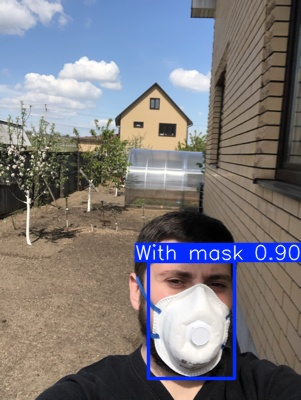

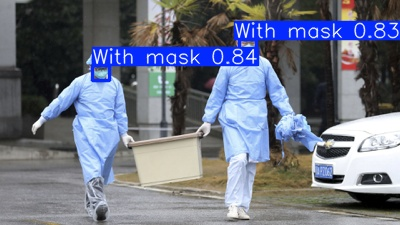

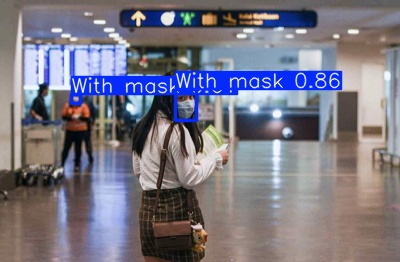

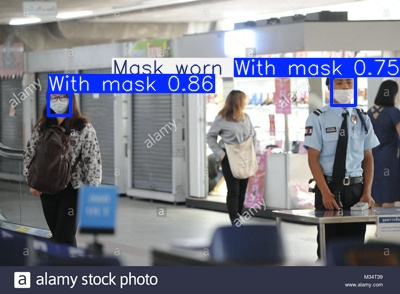

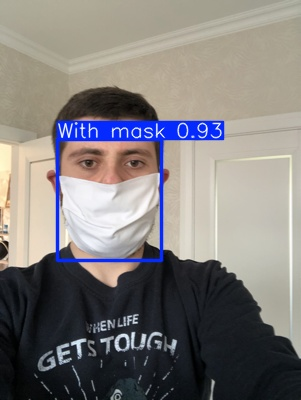

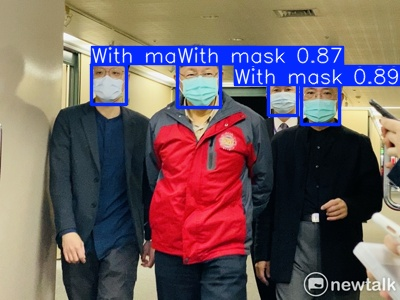

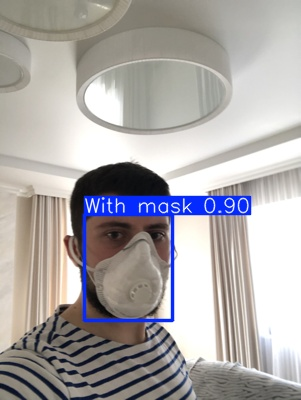

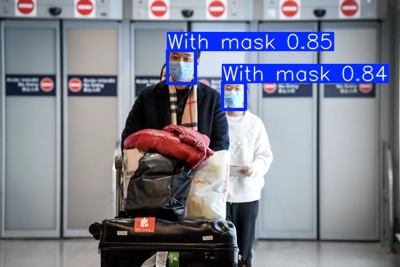

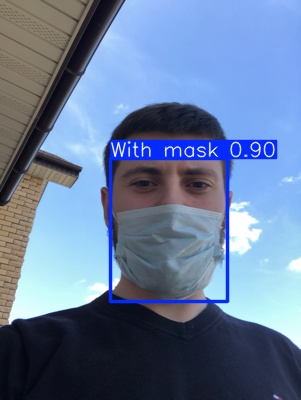

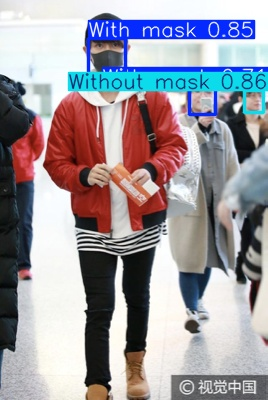

In [12]:
# Python's glob module searches for file path names that match
# the pattern of Unix's shell rules
import glob

from IPython.display import Image, display
for path in glob.glob(f'/content/runs/detect/predict/*.jpg')[:10]:
  display(Image(filename=path, height=620))
  print('\n')

If the results seem off or inaccurate, you can ask me (Nam) to take a look at your copy of the notebook. In general though, these are a few steps you can take to check and change your model:

*   Double-check your dataset to see if there are any labeling errors or contradictory examples
*   Increase the number of training epochs
*   Use a larger model size, such as YOLO26l, YOLO26xl, etc.
*   Increase the dataset by adding more labeled images



## 5. Download Model
Now that the model has been successfully trained and tested, you can actually try it out.

Some potential ideas to expand upon this model and incorporate into a larger program include an efficiency detector (based on studies determining the effectiveness of different types of face masks) or a "worn correctly" detector.

*This is good practice to develop your own datasets and/or apply ML models into applications*.

Let's zip the model (its weights and training results) and download them.

In [13]:
# Store model weights and training results in new dir
!mkdir /content/trained_model/
!cp /content/runs/detect/train/weights/best.pt /content/trained_model/trained_model.pt
!cp -r /content/runs/detect/train /content/trained_model

# Zip weights and model
%cd trained_model
!zip /content/model.zip trained_model.pt
!zip -r /content/model.zip train
%cd /content

/content/trained_model
  adding: trained_model.pt (deflated 8%)
  adding: train/ (stored 0%)
  adding: train/results.csv (deflated 61%)
  adding: train/confusion_matrix.png (deflated 27%)
  adding: train/val_batch2_pred.jpg (deflated 6%)
  adding: train/train_batch0.jpg (deflated 4%)
  adding: train/train_batch1.jpg (deflated 5%)
  adding: train/train_batch1290.jpg (deflated 9%)
  adding: train/BoxR_curve.png (deflated 11%)
  adding: train/BoxP_curve.png (deflated 12%)
  adding: train/results.png (deflated 7%)
  adding: train/BoxPR_curve.png (deflated 15%)
  adding: train/confusion_matrix_normalized.png (deflated 23%)
  adding: train/val_batch1_labels.jpg (deflated 8%)
  adding: train/train_batch1292.jpg (deflated 10%)
  adding: train/val_batch0_pred.jpg (deflated 5%)
  adding: train/val_batch2_labels.jpg (deflated 6%)
  adding: train/BoxF1_curve.png (deflated 9%)
  adding: train/train_batch1291.jpg (deflated 11%)
  adding: train/weights/ (stored 0%)
  adding: train/weights/last.pt (de

This is the more proper code-block you can run to download the model, but if it's taking a while to run, you can just download it from the sidebar.

In [14]:
from google.colab import files

files.download('/content/model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 6. Local Deployment
Now, let's get the model running locally on your PC. You can also use a Raspberry Pi (auxiliary hardware) to run the model, but for the sake of the workshop we'll just deploy locally. Watch this video [here](https://www.youtube.com/watch?v=z70ZrSZNi-8) to learn more about it!

#### 6.1) Download Anaconda
First, download and install Anaconda (https://anaconda.com/download) on your computer. Anaconda is a virtual Python environment that lets you easily run Ultralytics and Pytorch on your device. It also auto-installs CUDA (Nvidia's parallel computing platform) and cuDNN, which will speed up model inference faster by using a Nvidia GPU.

#### 6.2) Setup Venv

After you install Anaconda, run Anaconda Prompt from the Start Bar (Windows) or Terminal (macOS or Linux).

The first line creates the environment (`--name` is the flag that indicates the name of our virtual environment (which we named `yolo-env`), and `-y` auto-confirms our prompt), and the second line activates it.
```
conda create --name yolo-env python=3.12 -y
conda activate yolo-env
```
We can then install Ultralytics in the virtual environment. Doing this also automatically installs import libraries like OpenCV-Python, NumPy, and PyTorch.

```
pip install ultralytics
```


#### 6.3) Extract Downloaded Model
Take your downloaded model from 5) and unzip it into a folder on your PC. Using the Anaconda Prompt terminal, move into this folder with this code.
```
cd "<insert path to folder>"
```
You can find the path to this folder by right-clicking, pressing Option, and selecting "Copy "model" as Pathname" (macOS) or copying and pasting the File Path at the top of the File Explorer path (Windows).

#### 6.4) Deploy

To deploy our model, we'll be using a modified version of [this](https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/yolo_detect.py) Python file (also written by EdjeElectronics on GitHub) that will allow us to connect our model to our webcam. Writing this yourself would definitely be more advanced, but if you're interested in learning how it works and how to implement one yourself, I highly recommend reading it over!

Download the Python file by running the following in the Anaconda Prompt terminal. The original only allows for images, videos, external webcams, and Raspberry Pi hardware, but I modified it to allow us to deploy it using our webcam.

```
curl -o yolo_detect.py https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/yolo_detect.py
```

Now we can run the script!

*   `--model` is the name of your model (`trained_model.pt` if using the previous code)
*   `--source` is the source of the images or videos, can be an image folder/directory, video file name, 'webcam', 'usb0' or 'picamera0'
*   `--resolution` is the resolution to display our inference results at
```
python yolo_detect.py --model trained_model.pt --source webcam --resolution 1280x720
```
